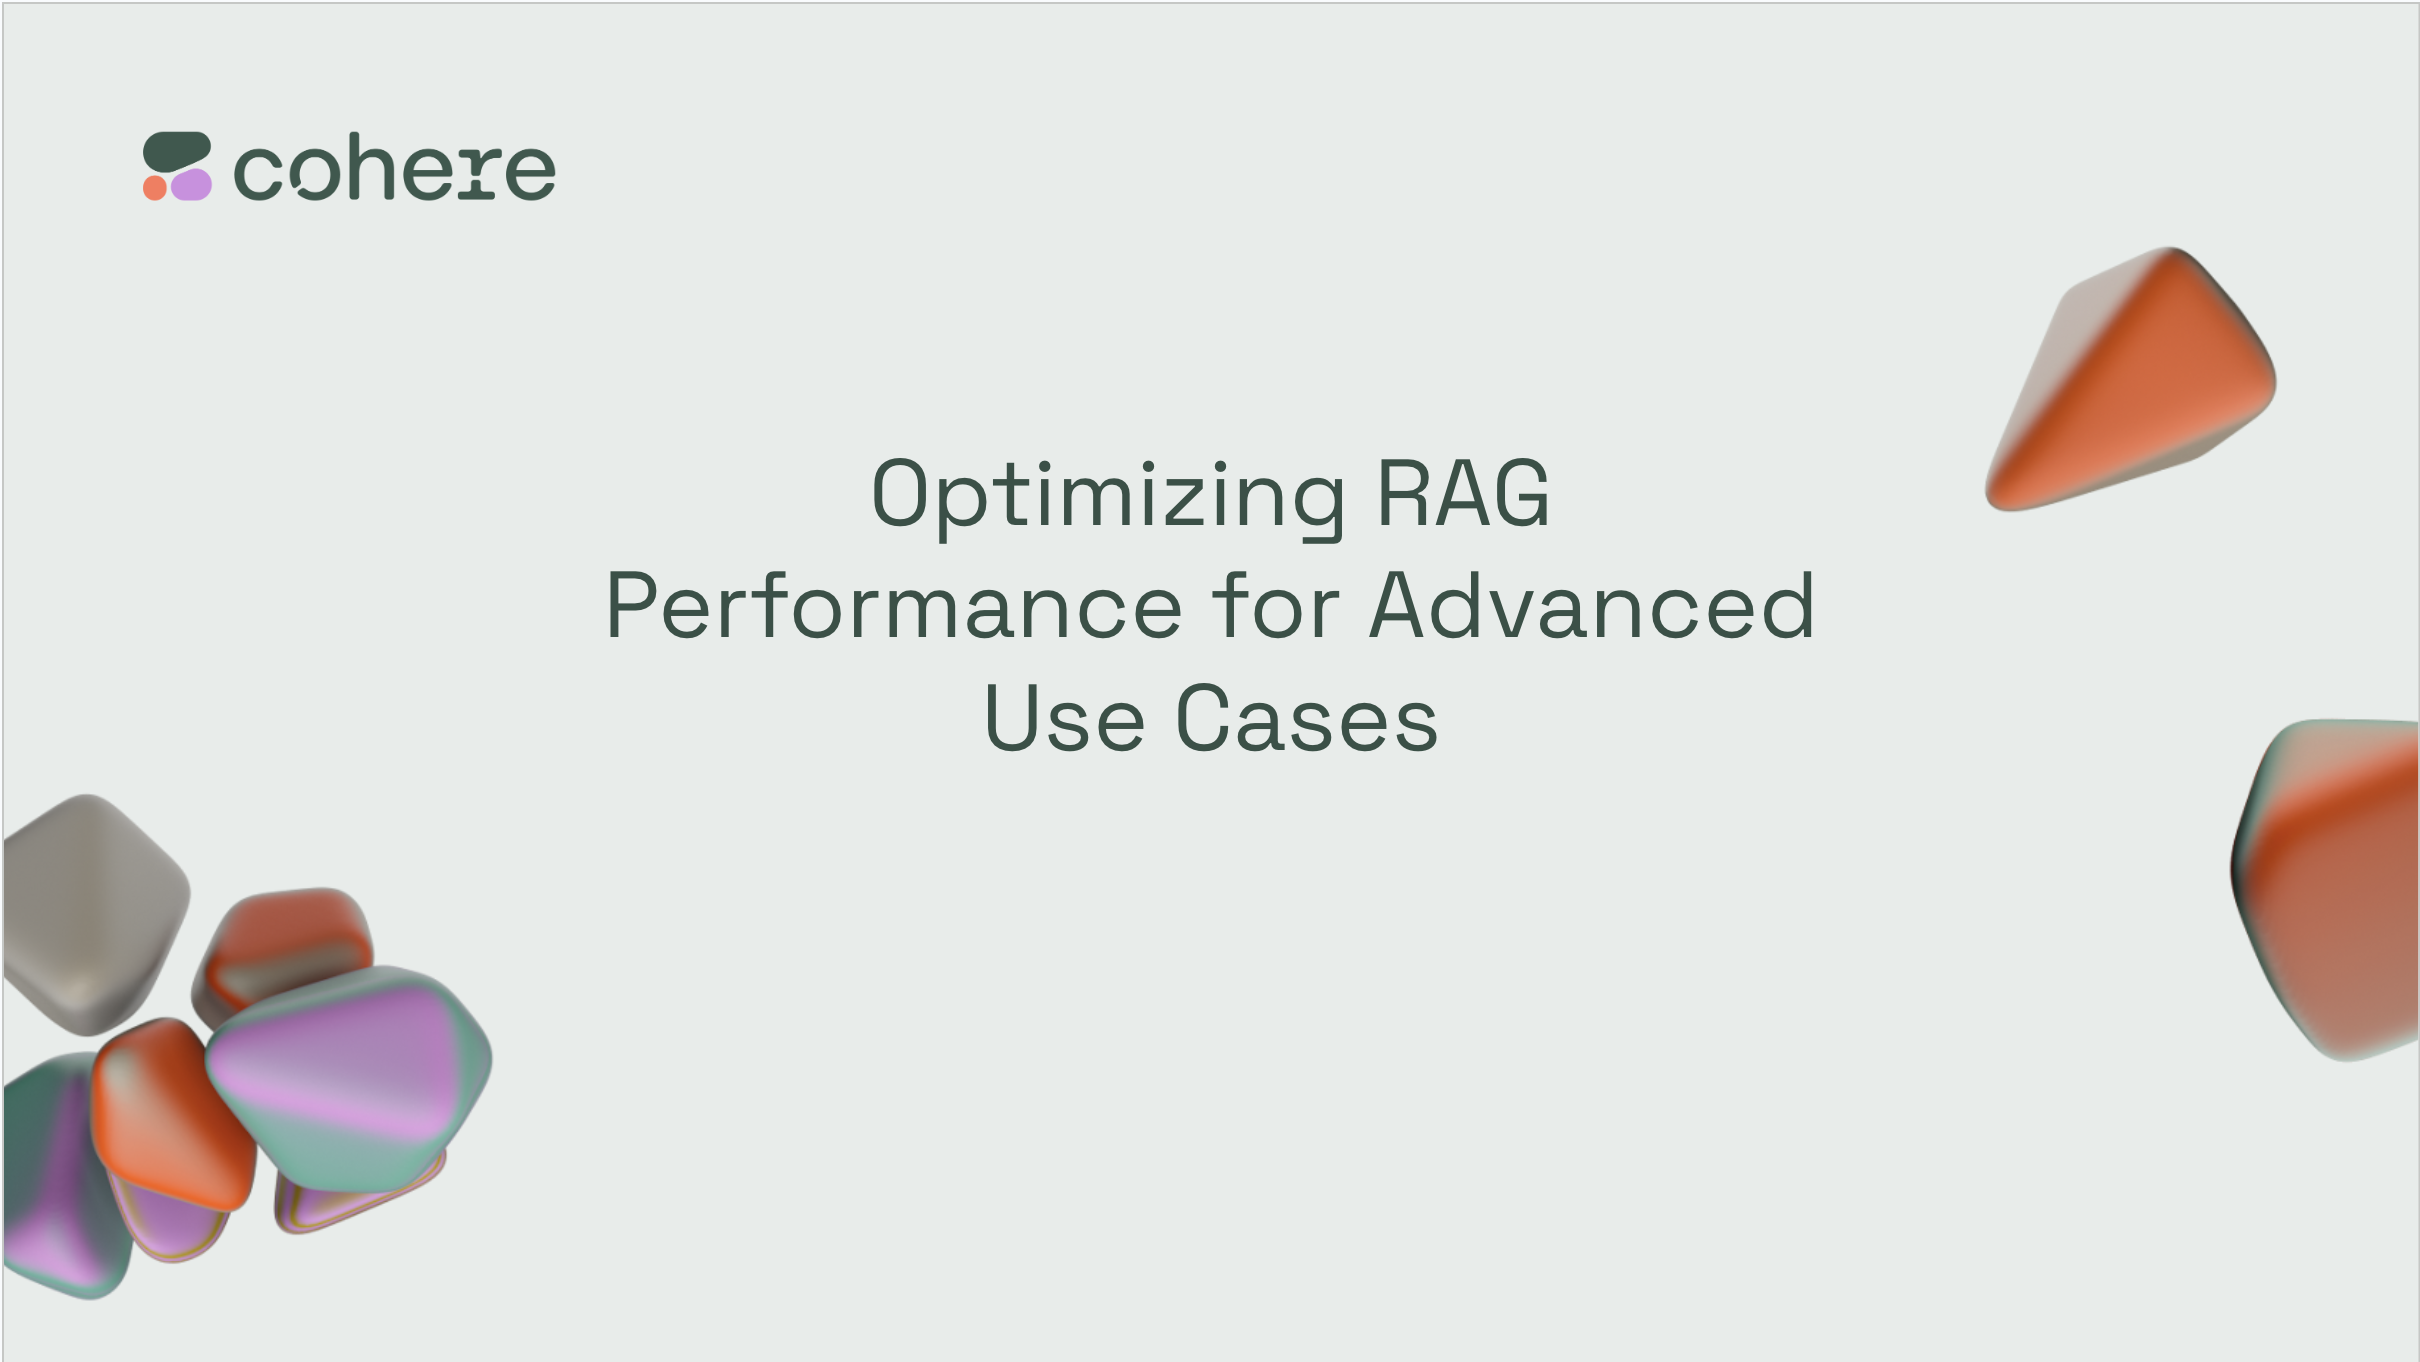

# What is RAG?
## To understand RAG, we will work with the example of a company that wants to deploy a chatbot as an intelligent knowledge assistant. For the chatbot to be useful, it will need to be connected to the company’s knowledge base.

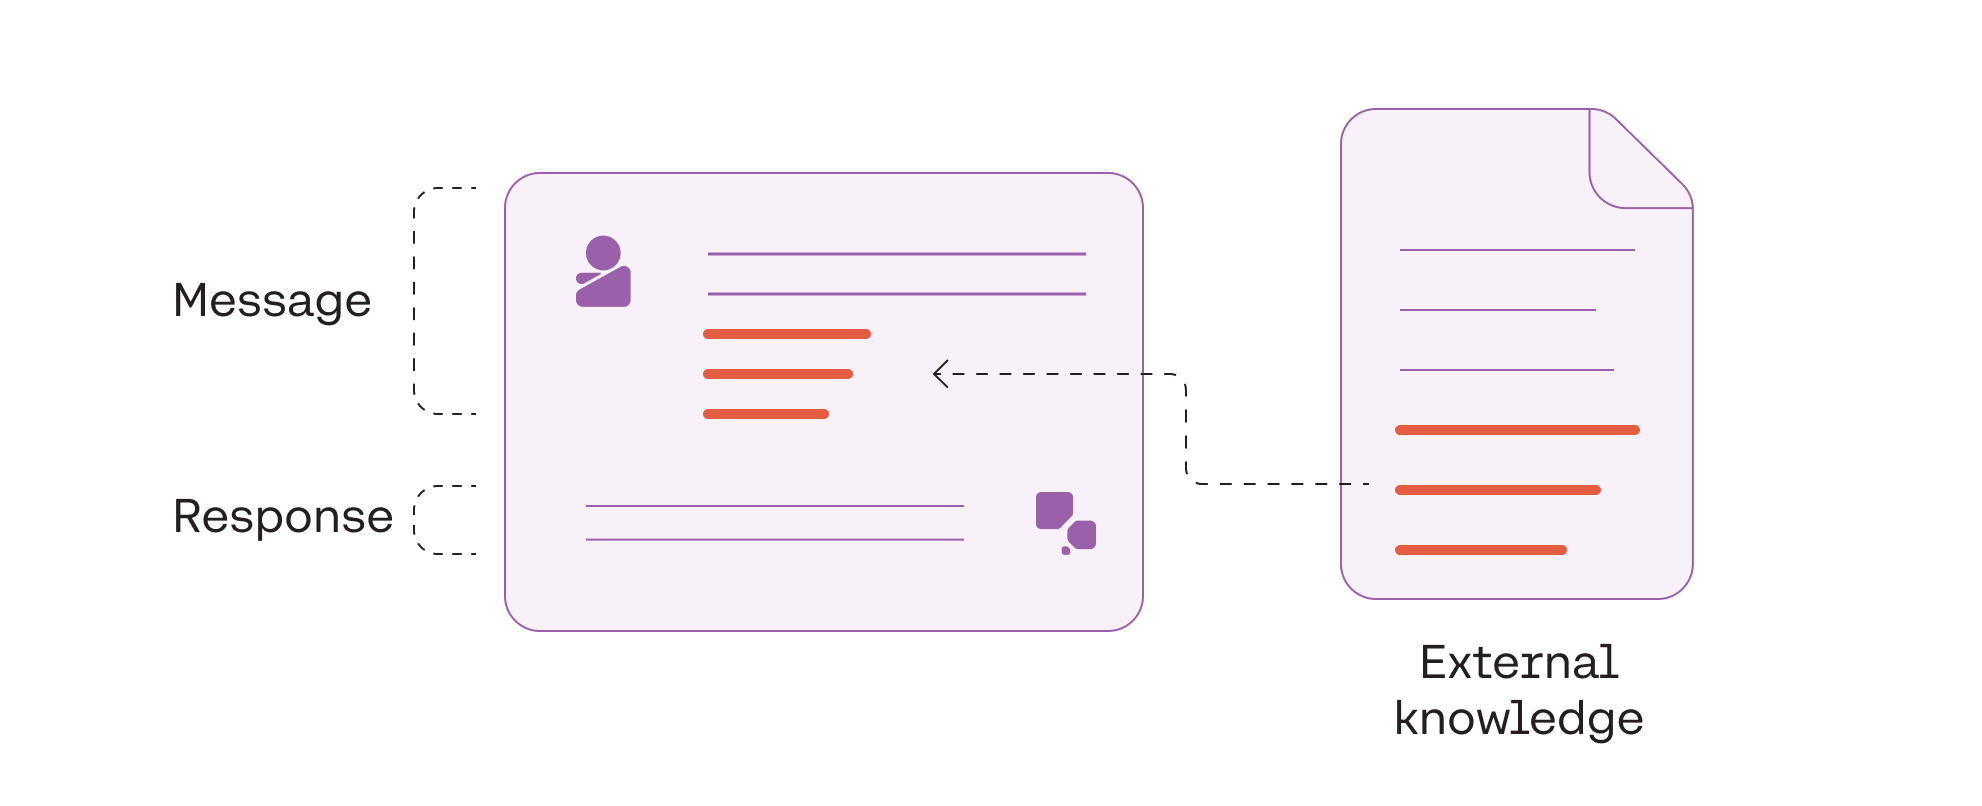
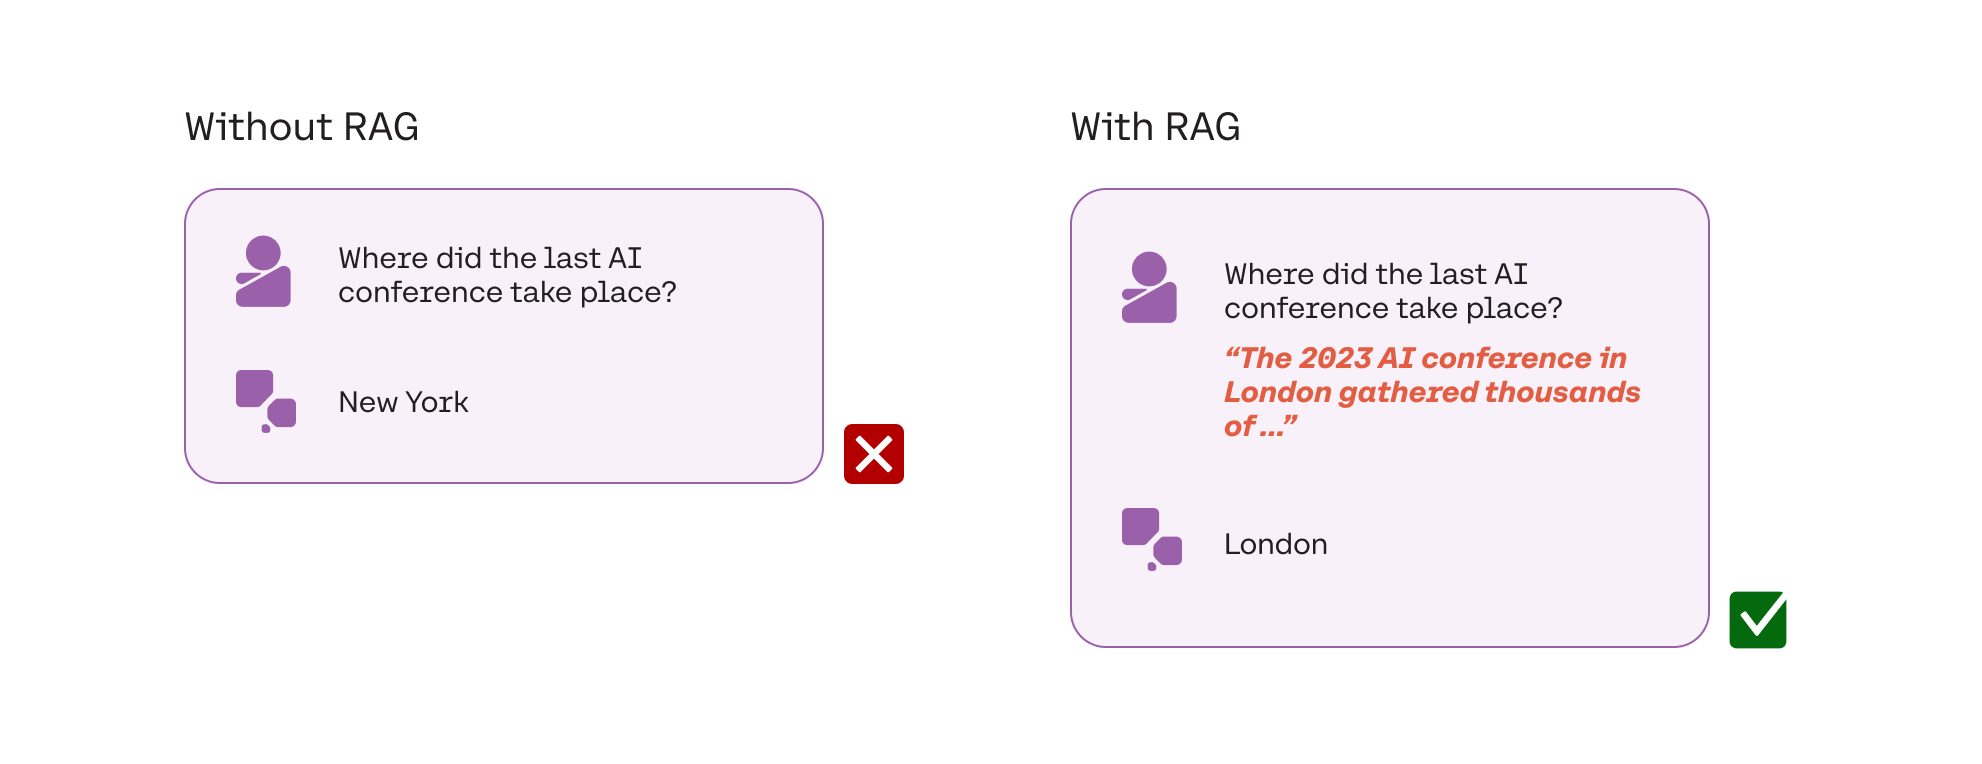

## RAG at a high level is a simple process...but there is a lot of subtle complexity
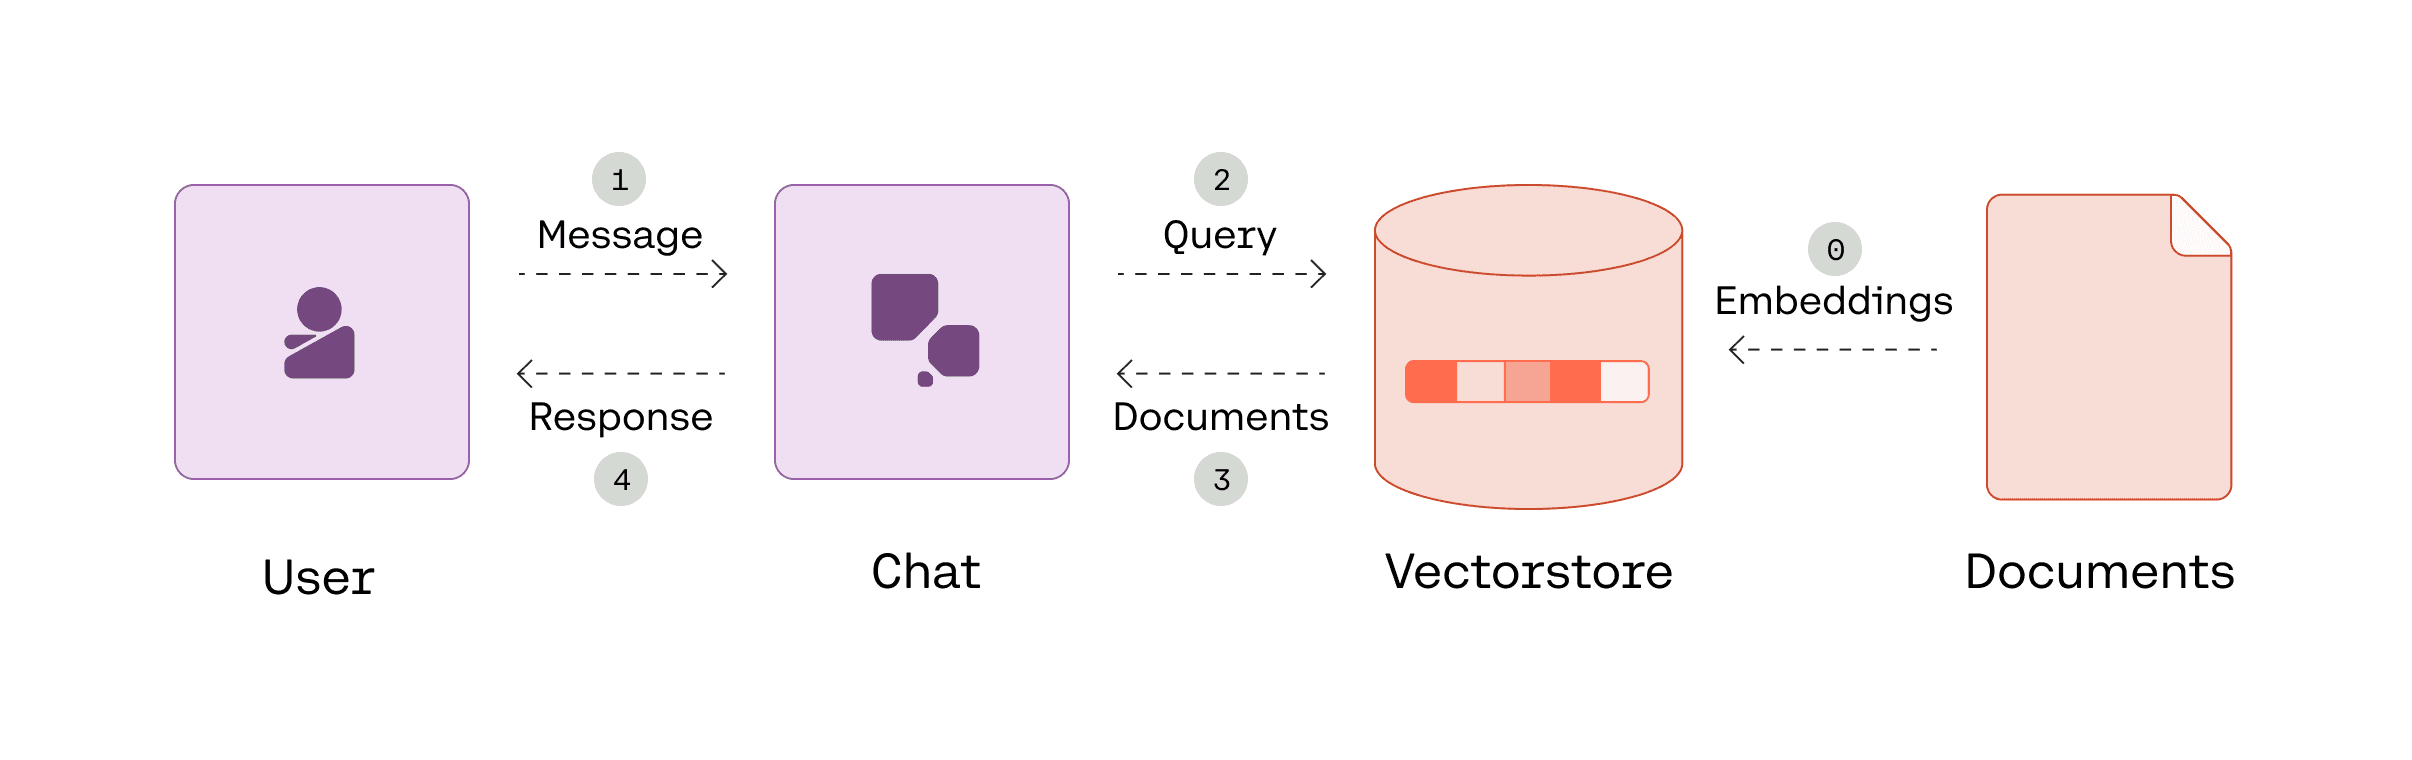

## Lets start by getting some data and building out our search process

### In this case, we already loaded some data into AI search, we have an index that we can use to compare some search methods
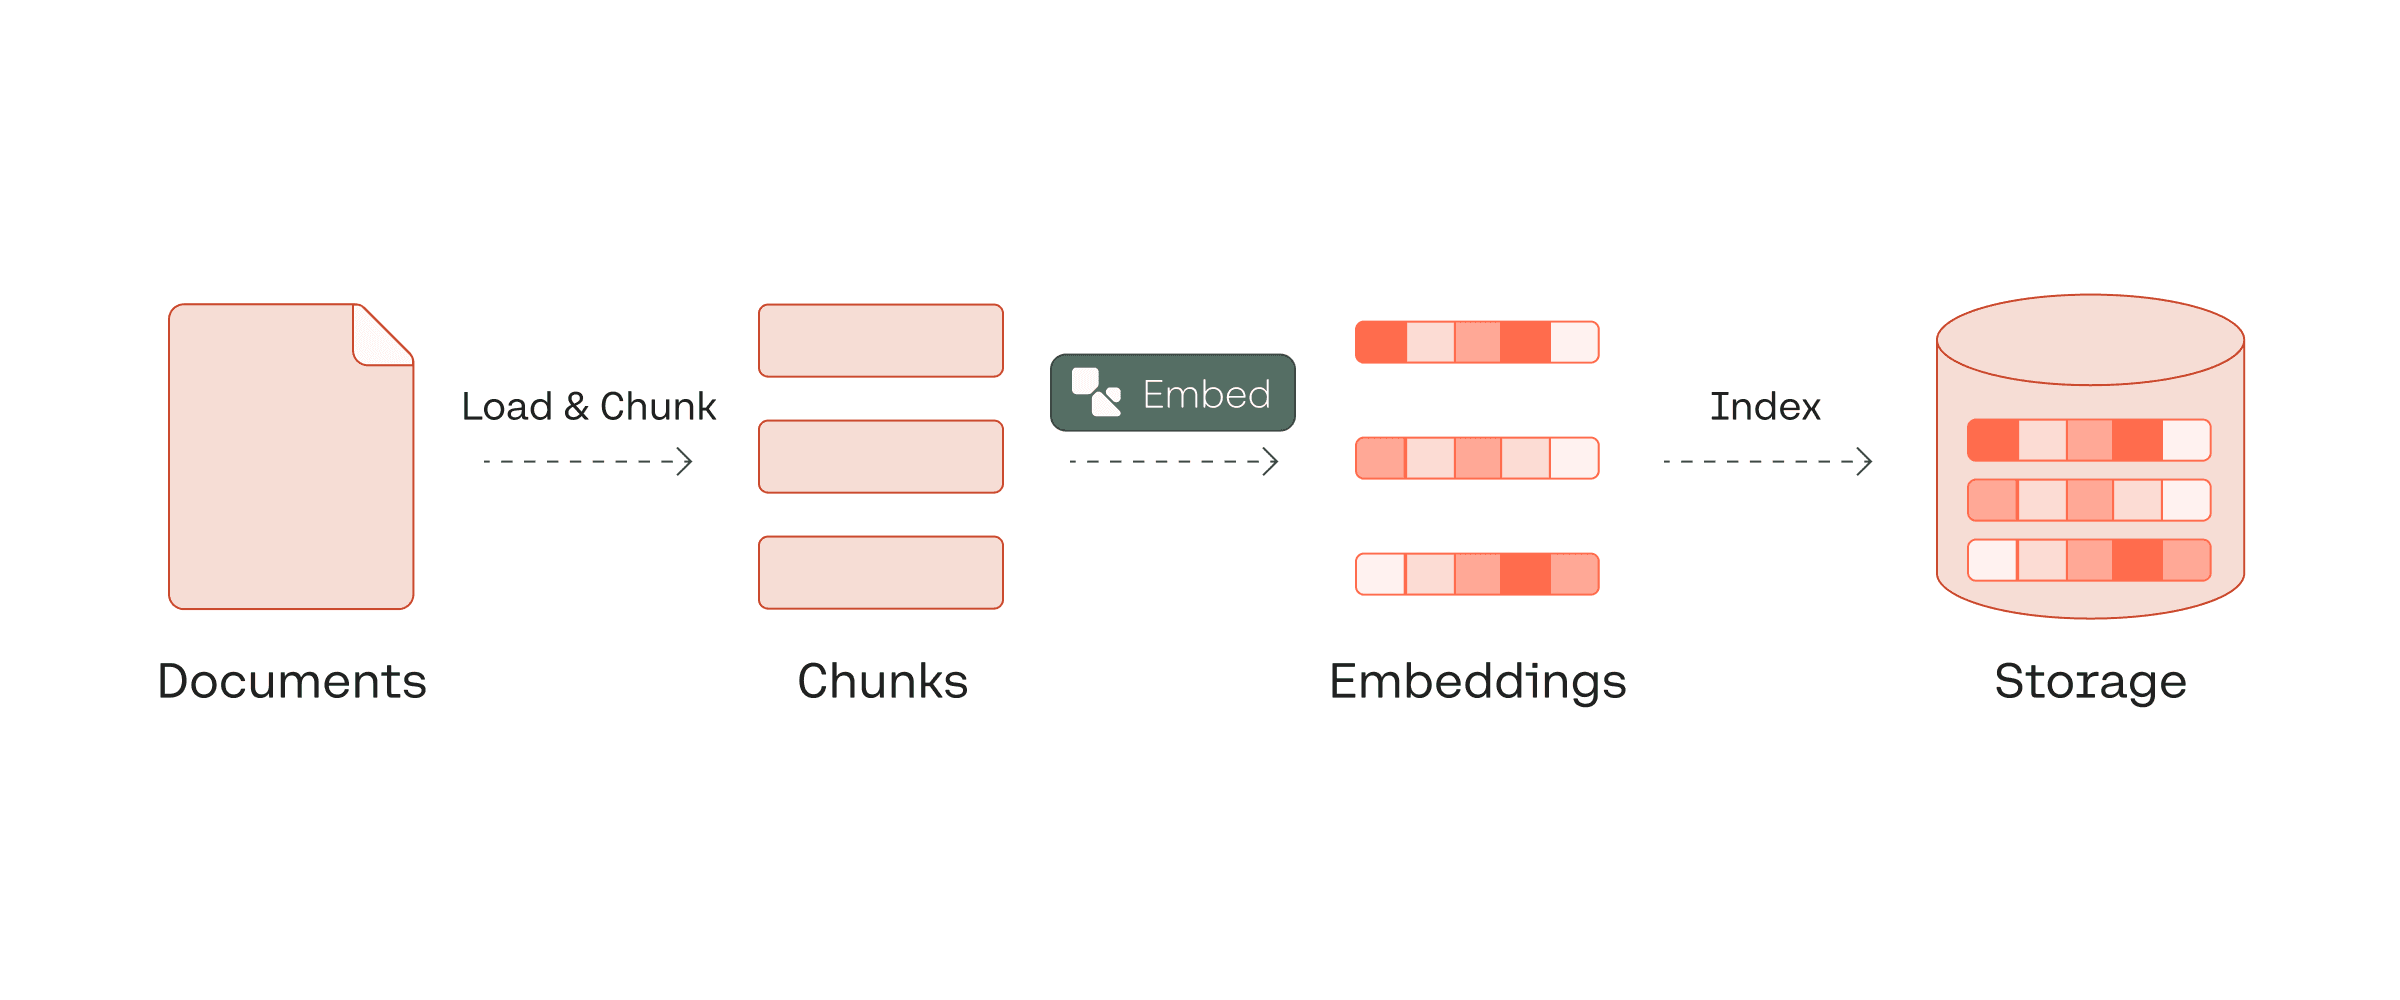

## Note
For the purposes of this demo, we created a vector index in advance. We used the trec-covid dataset along with Azure AI Search. For more instructions and a walkthrough of creating this index, please reference the [Cohere AI Search example here](https://github.com/Azure/azureml-examples/blob/main/sdk/python/foundation-models/cohere/cohere-aisearch-rag.ipynb).


### First lets look at vector search with our data and compare to lexical and hybrid

In [ ]:
import os
import cohere
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizedQuery

In [ ]:
co = cohere.Client(os.environ['COHERE_API_KEY'])

In [ ]:
# Some credentials
search_service_endpoint = os.environ['search_service_endpoint']
key_credential = AzureKeyCredential(os.environ['key_credential'])
index_name = os.environ['index_name']

In [ ]:
# Set up our search client
search_client = SearchClient(
    endpoint=search_service_endpoint,
    index_name='build_demo',
    credential=key_credential
    )

#### We will create a helper function to compare our different search methods. It will use the same index, but leverage different search approaches

In [ ]:
# Search function to encode the query and search the index
def search(query, mode, rerank=False, n_docs=75):
    """
    Searches for documents based on the given query.

    Args:
        query (str): The search query.
        mode (str): The search mode ('semantic', 'lexical', or 'hybrid').
        rerank (bool): Whether to re-rank the results. Defaults to False.
        n_docs (int): The number of documents to retrieve. Defaults to 75.

    Returns:
        list: A list of search results.
    """
    query_embedding = co.embed(texts=[query], input_type='search_query', model='embed-english-v3.0').embeddings[0]
    vector_query = VectorizedQuery(vector=query_embedding, k_nearest_neighbors=n_docs, fields="vector")

    search_params = {
        'semantic': {
            'search_text': None,
            'vector_queries': [vector_query],
        },
        'lexical': {
            'search_text': query,
            'vector_queries': None,
        },
        'hybrid': {
            'search_text': query,
            'vector_queries': [vector_query],
        }
    }

    params = search_params.get(mode, search_params['lexical'])
    search_results = search_client.search(
        select=["id", "title", "text"],
        top=n_docs,
        **params
    )

    return [doc for doc in search_results]


In [ ]:
# So lets search for something
query = 'Have there been any studies on natural treatment for diabetes?'

In [562]:
vector_results = search(query, mode='semantic')

### We can also get the keyword search results

In [563]:
keyword_results = search(query, mode='lexical')

### Or both using Reciprocal Rank Fusion (RRF)

In [564]:
hybrid_results = search(query, mode='hybrid')

### So lets see how they compare

In [565]:
import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_colwidth', 0)

df = pd.DataFrame()
df['semantic'] = vector_results
df['lexical'] = keyword_results
df['hybrid'] = hybrid_results

In [566]:
# Convert DataFrame to HTML with custom styles
html = df[:5].to_html(escape=False)

# Display the DataFrame with custom styles
display(HTML(html))

,semantic,lexical,hybrid
0,"{'text': 'The morbidity of type 2 diabetes mellitus (T2DM) has been increasing rapidly worldwide. Tangminling pill, consisting of ten Chinese herbal medications, is usually prescribed for T2DM in mainland China. Whether treatment with Tangminling can improve clinical outcomes of T2DM patients was still debated. Four studies comparing Tangminling vs. placebo treatment in T2DM patients were included and 767 T2DM patients were enrolled in our analyses. Tangminling treatment exhibited better efficacy than placebo in reducing hemoglobin A1c (HbA1c) (1.11 vs. 0.32%; pooled weighted mean difference [WMD]: 0.80; 95% confidence interval [CI]: 0.65–0.96; P<0.001), fasting plasma glucose (0.82 vs. −0.40 mM; WMD: 1.10; 95% CI: 0.56–1.64; P<0.001), 2-h postprandial glucose (2-hr PG) (2.81 vs. 1.11 mM; WMD: 1.80; 95% CI: 1.72–1.88; P<0.001), homeostatic model assessment-β level (4.28 vs. 0.41; WMD: 0.44; 95% CI: 0.27–0.61; P<0.001), waist circumference (WC) (1.04 vs. 0.36 cm; WMD: 0.78; 95% CI: 0.37–1.19; P<0.001) and body weight index (0.37 vs. 0.11 kg/m(2); WMD: 0.30; 95% CI: −0.00 to 0.61; P=0.05). Tangminling pill might reduce glucose level and body weight and improve β-cell function in T2DM patients. Our study highlights the important role of Tangminling pill in the management of T2DM.', 'id': 'a334btay', 'title': 'Efficacy of traditional Chinese medication Tangminling pill in Chinese patients with type 2 diabetes', '@search.score': 0.6936568, '@search.reranker_score': None, '@search.highlights': None, '@search.captions': None}","{'text': 'The high prevalence of type 2 diabetes mellitus in the world as well as the increasing reports about the adverse side effects of the existing diabetes treatment drugs have made developing new and effective drugs against the disease a very high priority. In this study, we report ten novel compounds found by targeting peroxisome proliferator-activated receptors (PPARs) using virtual screening and core hopping approaches. PPARs have drawn increasing attention for developing novel drugs to treat diabetes due to their unique functions in regulating glucose, lipid, and cholesterol metabolism. The reported compounds are featured with dual functions, and hence belong to the category of dual agonists. Compared with the single PPAR agonists, the dual PPAR agonists, formed by combining the lipid benefit of PPARα agonists (such as fibrates) and the glycemic advantages of the PPARγ agonists (such as thiazolidinediones), are much more powerful in treating diabetes because they can enhance metabolic effects while minimizing the side effects. This was observed in the studies on molecular dynamics simulations, as well as on absorption, distribution, metabolism, and excretion, that these novel dual agonists not only possessed the same function as ragaglitazar (an investigational drug developed by Novo Nordisk for treating type 2 diabetes) did in activating PPARα and PPARγ, but they also had more favorable conformation for binding to the two receptors. Moreover, the residues involved in forming the binding pockets of PPARα and PPARγ among the top ten compounds are explicitly presented, and this will be very useful for the in-depth conduction of mutagenesis experiments. It is anticipated that the ten compounds may become potential drug candidates, or at the very least, the findings reported here may stimulate new strategies or provide useful insights for designing new and more powerful dual-agonist drugs for treating type 2 diabetes.', 'id': 'icwhpbpj', 'title': 'Find novel dual-agonist drugs for treating type 2 diabetes by means of cheminformatics', '@search.score': 20.458666, '@search.reranker_score': None, '@search.highlights': None, '@search.captions': None}","{'text': 'The high prevalence of type 2 diabetes mellitus in the world as well as the increasing reports about the adverse side effects of the existing diabetes treatment drugs have made developing new and effective drugs against th

#### The results are okay, but they can be improved further, as the result im looking for (talking about a particular tree) are too low in the list to get picked up

## Enter Semantic reranking
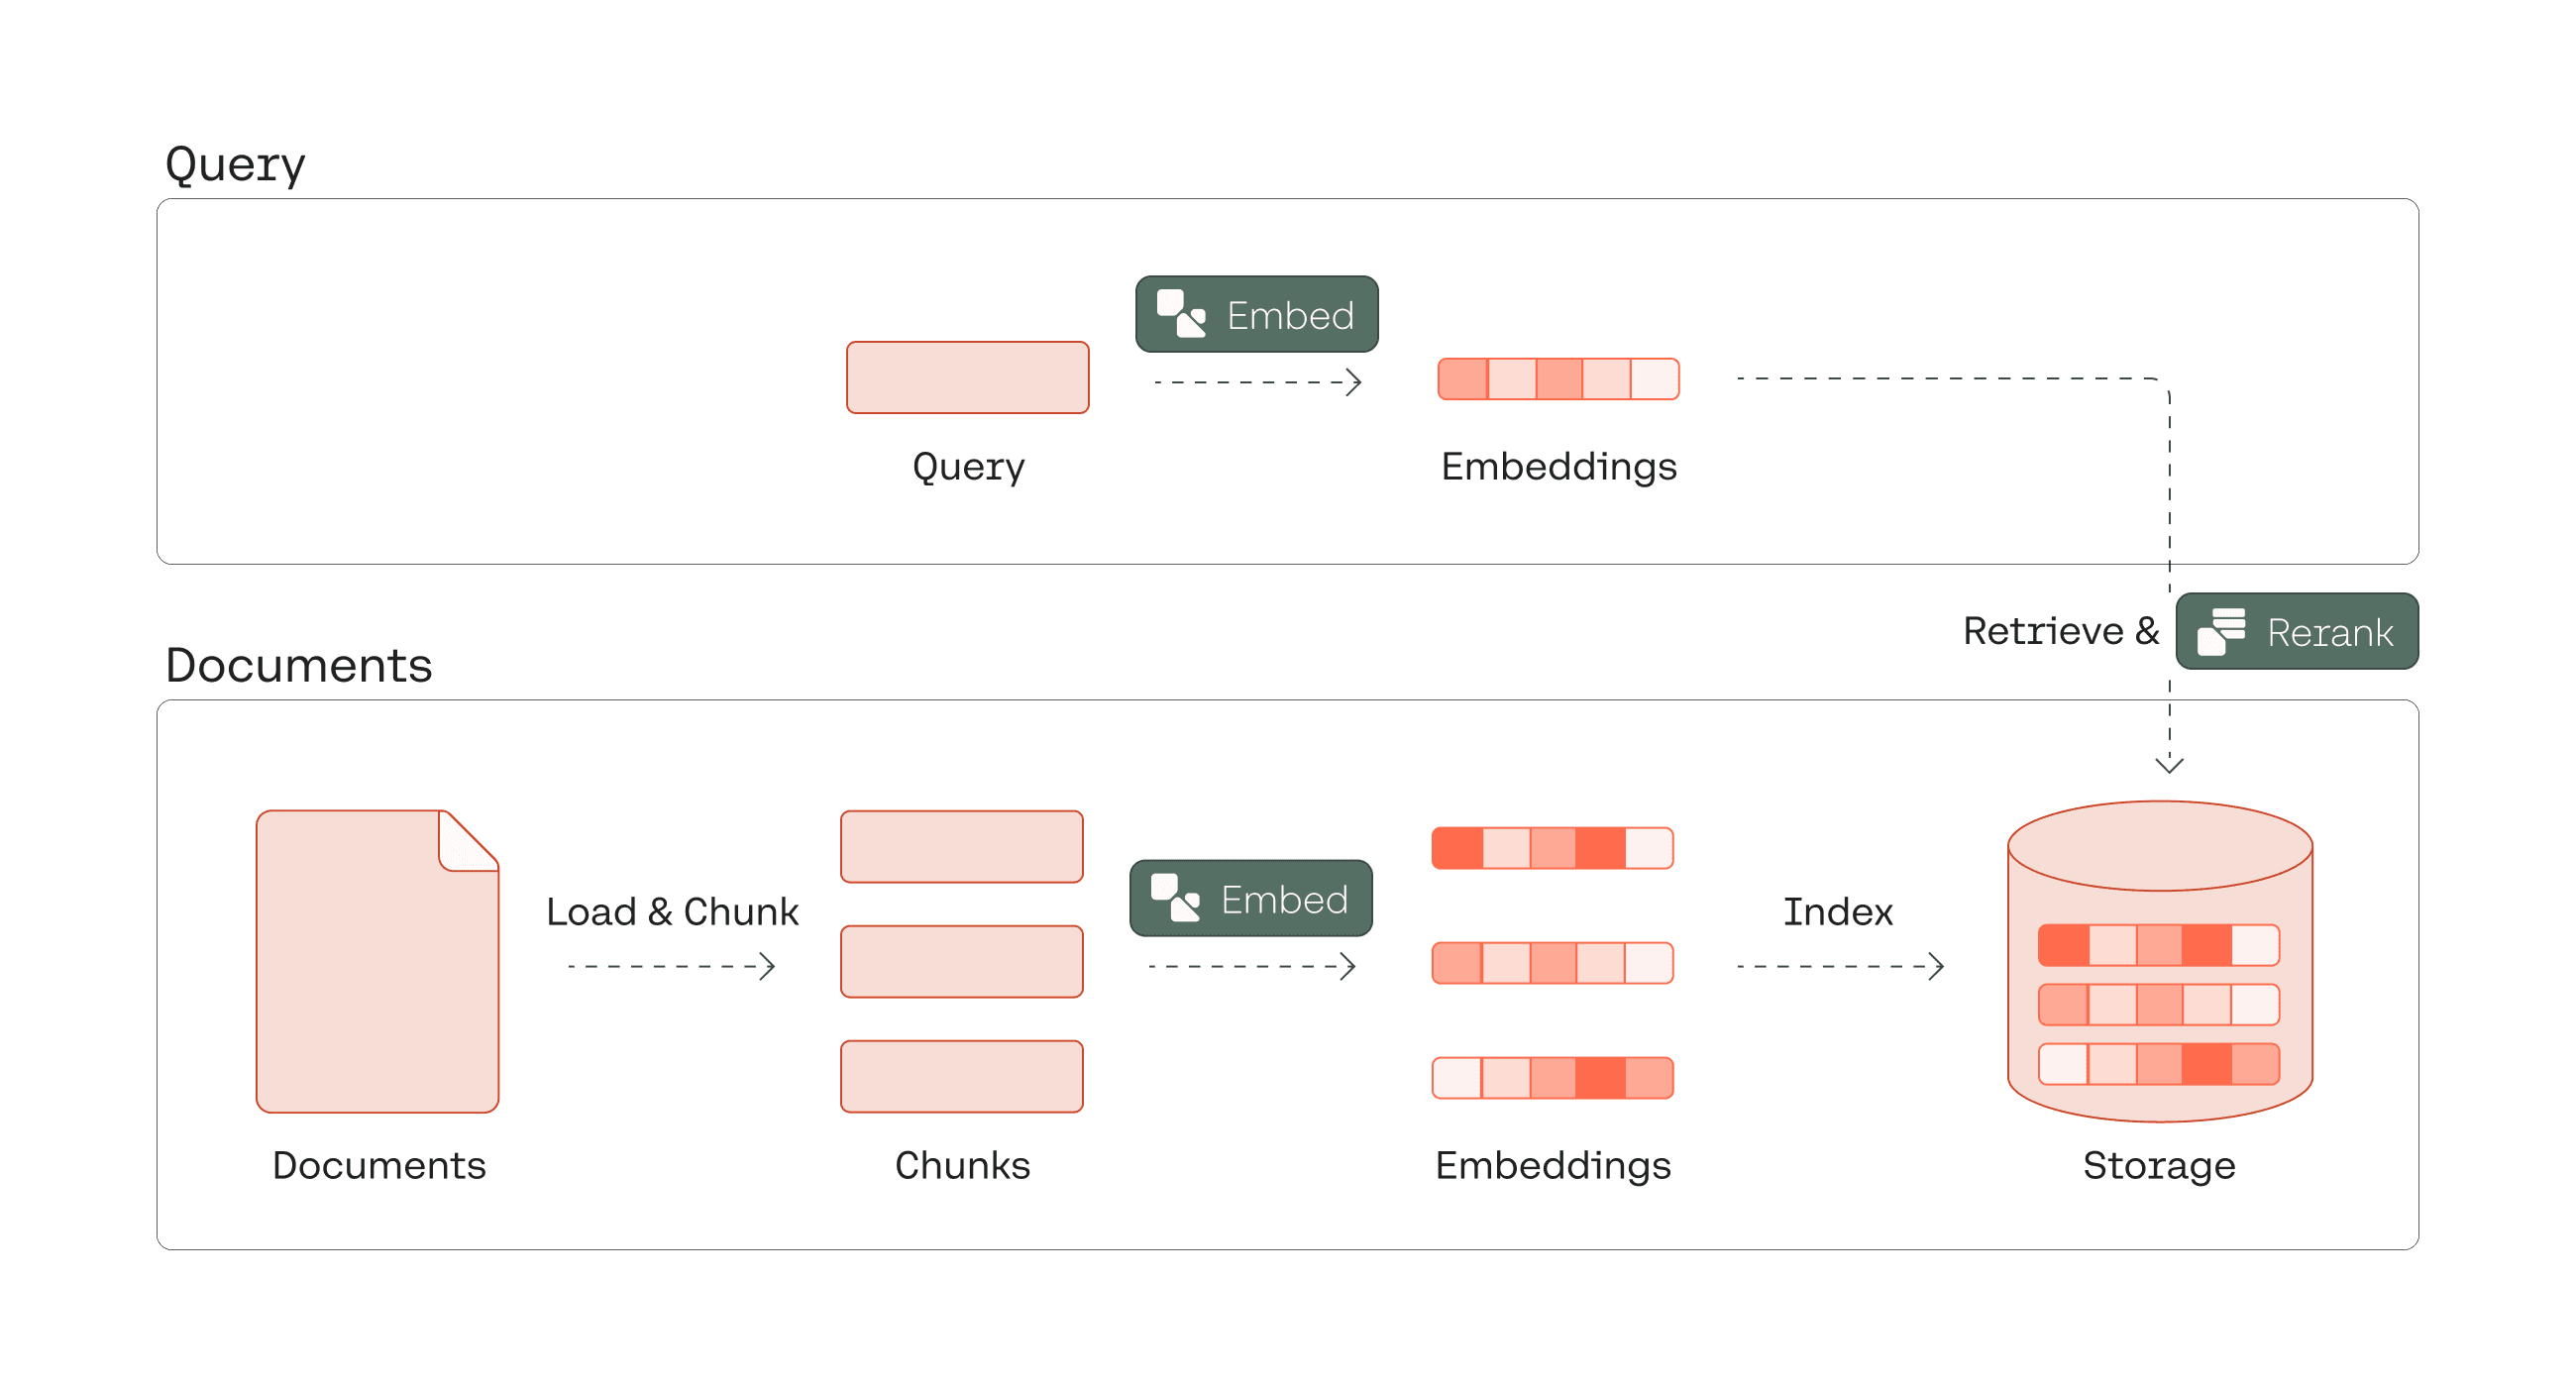

### Instead of taking just the semantic or lexical results, lets take both and run the results through rerank

In [ ]:
# We will create one list of our initial results
first_stage_results = vector_results + keyword_results
len(first_stage_results)

In [567]:
# Rerank the results
reranked_results = co.rerank(query=query,
                             documents=first_stage_results,
                             top_n=10,
                             rank_fields=['text', 'title'],
                             model='rerank-english-v3.0',
                             return_documents=True)

## Now we can look at the updated results

In [568]:
for doc in reranked_results.results:
    print(doc.document.title)
    print(doc.document.text)
    print(f"\n{'-'*50}\n")

Antidiabetes and Anti-obesity Activity of Lagerstroemia speciosa
The leaves of Lagerstroemia speciosa (Lythraceae), a Southeast Asian tree more commonly known as banaba, have been traditionally consumed in various forms by Philippinos for treatment of diabetes and kidney related diseases. In the 1990s, the popularity of this herbal medicine began to attract the attention of scientists worldwide. Since then, researchers have conducted numerous in vitro and in vivo studies that consistently confirmed the antidiabetic activity of banaba. Scientists have identified different components of banaba to be responsible for its activity. Using tumor cells as a cell model, corosolic acid was isolated from the methanol extract of banaba and shown to be an active compound. More recently, a different cell model and the focus on the water soluble fraction of the extract led to the discovery of other compounds. The ellagitannin Lagerstroemin was identified as an effective component of the banaba extrac

## So what does this mean?
### To see the impact, lets set up our chat portion of the RAG flow so that we can respond to the user. This function will make it easier to test the chat portion of our RAG flow

In [ ]:
# We will create a basic chat helper function
import uuid

class Chat:
    def __init__(self, rerank=False, n_search_results=75):
        self.convo_id = uuid.uuid4()
        self.rerank = rerank
        self.n_search_results = n_search_results
    
    def _rerank_documents(self, query, keyword_docs, semantic_docs, top_n=10):
        """
        Re-ranks the combined keyword and semantic documents and formats them.

        Args:
            query (str): The search query.
            keyword_docs (List[Dict]): Keyword search results.
            semantic_docs (List[Dict]): Semantic search results.

        Returns:
            str: Formatted re-ranked documents as a string.
        """
        first_stage_results = keyword_docs + semantic_docs
        reranked_results = co.rerank(
            query=query,
            documents=first_stage_results,
            top_n=top_n,
            rank_fields=['text', 'title'],
            model='rerank-english-v3.0',
            return_documents=True
        )
        
        documents = [doc.document for doc in reranked_results.results]
        return documents
    
        
    def _search(self, query):
        # get the search results
        keyword_documents = search(query, mode='lexical')
        semantic_documents = search(query, mode='semantic')
        hybrid_documents = search(query, mode='hybrid')
        
        # If we want to use rerank
        if self.rerank:
            documents = self._rerank_documents(query, keyword_documents, semantic_documents)
        
        # otherwise default to hybrid
        else:
            documents = hybrid_documents[:self.n_search_results]
        
        return documents
        
    
    def chat(self, message):
        """
        Generates a chat response based on the given message.

        Args:
            message (str): The user's input message.

        Yields:
            str: The chat response generated by the model.
        """
        # get the search results
        documents = self._search(message)
        
        # If we want to use rerank
        if self.rerank:
            documents_str = '\n'.join([f"\nDocument: {i}\n{d.title}\n\n{d.text}" for i, d in enumerate(documents)])
        
        # otherwise default to hybrid
        else:
            documents_str = '\n'.join([f"\nDocument: {i}\n{d['title']}\n\n{d['text']}" for i, d in enumerate(documents)])
            
        # Chat model
        document_token_count = len(co.tokenize(text=documents_str, model='command-r-plus').tokens)
        print(f"{document_token_count} Tokens in the Prompt")
        
        model_response = co.chat_stream(
            message=f"Retrieved Documents:\n{documents_str}\n\nUser Message:\n{message}",
            preamble="Answer the user's question using information in the documents below",
            model="command-r-plus",
            temperature=0.1,
            conversation_id=self.convo_id
        )
        
        for token in model_response:
            if token.event_type == 'text-generation':
                yield token.text

### Lets try asking the model without reranking

In [ ]:
import time

In [569]:
no_rerank_session = Chat(rerank=False)

In [570]:
start_time = time.time()

# Asking our question
res = no_rerank_session.chat('Have there been any studies on natural treatment for diabetes?')

first_token = next(res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time before the response starts printing: {elapsed_time:.2f} seconds\n")
print(first_token, end='')
for r in res:
    print(r, end='')

26369 Tokens in the Prompt
Time before the response starts printing: 4.57 seconds

There have been several studies on natural treatments for diabetes. Here are some of the findings:

- A study on the efficacy of the Tangminling pill, a Chinese medication consisting of ten herbal medicines, found that it was more effective than a placebo in reducing glucose levels and body weight, and improving β-cell function in patients with type 2 diabetes.
- Lagerstroemia speciosa, a Southeast Asian tree commonly known as banaba, has been traditionally consumed in the Philippines for treating diabetes and kidney-related diseases. Scientific studies have confirmed its antidiabetic activity.
- A study on the effects of extracts from the root bark of Broussonetia papyrifera found that it improved glucose intolerance and decreased inflammation in adipose tissue, indicating its therapeutic potential for metabolic diseases such as type 2 diabetes.
- A review of the use of herbal products in chronic liver 

### What if we use rerank instead?

In [571]:
rerank_session = Chat(rerank=True)

In [572]:
start_time = time.time()

# Asking our question
res = rerank_session.chat('Have there been any studies on natural treatment for diabetes?')

first_token = next(res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time before the response starts printing: {elapsed_time:.2f} seconds\n")
print(first_token, end='')
for r in res:
    print(r, end='')

3043 Tokens in the Prompt
Time before the response starts printing: 1.54 seconds

Yes, there have been studies on natural treatments for diabetes. Here are some examples:

- The leaves of the Lagerstroemia speciosa (Lythraceae) tree, commonly known as banaba, have been used by Filipinos to treat diabetes and kidney-related diseases. Scientists have identified different components of banaba that are responsible for its antidiabetic activity.
- The Tangminling pill, consisting of ten Chinese herbal medications, is prescribed for type 2 diabetes in mainland China. Studies have shown that it may reduce glucose levels and body weight and improve β-cell function in patients.
- Sphaeranthus indicus Linn. (Asteraceae) is used in Ayurvedic medicine to treat diabetes, among other conditions. It has been reported to have antihyperglycemic activities.
- Genetically engineered recombinant probiotics have been proposed as a treatment strategy for diabetes. A study found that an Ang(1–7)-secreting La

#### You can see we can effectively reduce both the latency and token count, while maintaining the high quality results

### But cant we pass in less documents with normal search?

In [573]:
short_session = Chat(rerank=False, n_search_results=10)

In [574]:
start_time = time.time()

# Asking our question
res = short_session.chat('Have there been any studies on natural treatment for diabetes?')

first_trerank_sessionoken = next(res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time before the response starts printing: {elapsed_time:.2f} seconds\n")
print(first_token, end='')
for r in res:
    print(r, end='')

3960 Tokens in the Prompt
Time before the response starts printing: 1.27 seconds

Yes, there have been studies on natural treatments for diabetes. One study examined the efficacy of the Tangminling pill, a Chinese medication consisting of ten herbal medications, in treating type 2 diabetes. Another study looked at the potential of withanolides, particularly extracts from Withania somnifera, in treating chronic diseases, including diabetes.

#### So we can, but the quality slips

### Alright so lets continue our conversation

In [575]:
res = rerank_session.chat("Can you tell me about some of the early symptoms of the disease?")
for r in res:
    print(r, end='')

3369 Tokens in the Prompt
Here are some early symptoms of various diseases:

- Dengue Virus Infection: fever, headache, retro-orbital pain, myalgia, arthralgia, rash, petechiae, positive tourniquet test, vomiting, leukopenia, platelets ≤150,000 cells/mL, poor capillary refill, cold extremities, and hypotension.
- Influenza: fever, respiratory symptoms, and myalgia.
- Pandemic H1N1 2009 Influenza: high fever, cough, rhinorrhea, sore throat, myalgia, and diarrhea.
- Swine-Origin Influenza A (H1N1): fever, cough, rhinorrhea, and headache.
- Early Infantile Pertussis: apnoeas, seizures, respiratory failure, hypotension, pulmonary hypertension, pneumothoraces, and seizures.
- Hantavirus Infection: disorientation, sinustachycardia, and hypotension.
- Chronic Kidney Disease (CKD): There are often no apparent symptoms in the early stages, especially in normotensive individuals. However, some novel biomarkers have been identified to detect early renal tubular damage, such as urinary vanin-1 and

#### Now we have a new failure mode, the model doesnt have the context from my conversation, so the search didnt return the correct results as it didnt know I meant for it to search for diabetes still

## We need to improve the queries
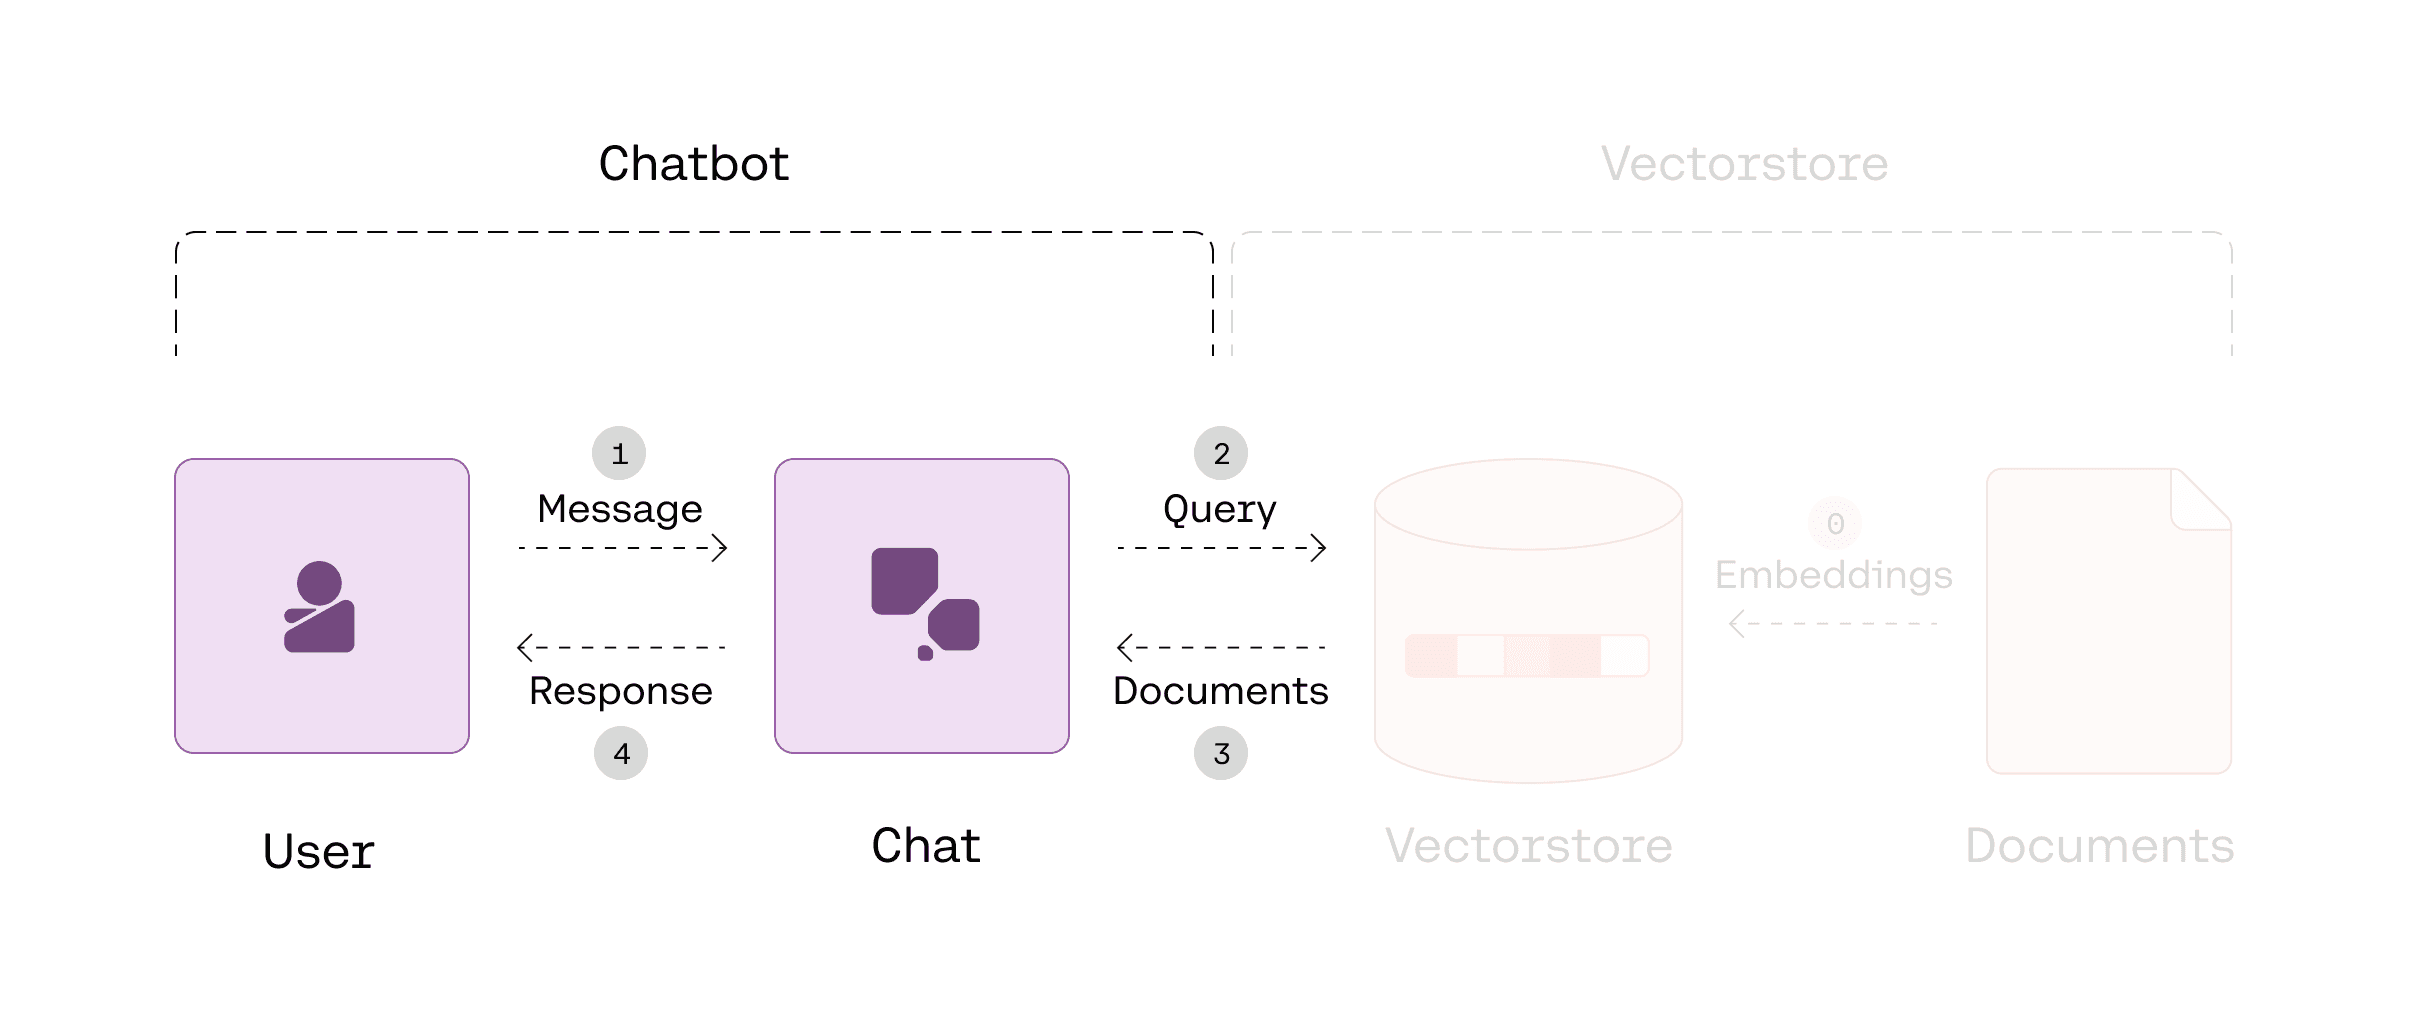
### We can make a new version of our chat class with a modification to use a model to create our query

In [576]:
class ContextChat(Chat):
    memory = []
    memory_str = ''
    
    def _set_context(self, message):
        self.memory.append(message)
        self.memory_str = '\n-'.join(self.memory)
        
    def _generate_query(self):
        prompt = f"Conversation:\n{self.memory_str} Use the context of the conversation above and return a rephrased query that takes into account the context of the conversation. Only return the query, nothing else"
        queries = []
        raw_generation = co.chat(message=prompt, model='command-r')
        query = raw_generation.text.strip()
        print(f"Generated Query: {query}")
        return query
        
    def chat(self, message):
        """
        Generates a chat response based on the given message.

        Args:
            message (str): The user's input message.

        Yields:
            str: The chat response generated by the model.
        """
        ###############################
        # Add a section to capture the context and get a new query
        #
        self._set_context(message)
        query = self._generate_query()
        ##############################
        
        # get the search results
        documents = self._search(query)
        
        # If we want to use rerank
        if self.rerank:
            documents_str = '\n'.join([f"\nDocument: {i}\n{d.title}\n\n{d.text}" for i, d in enumerate(documents)])
        
        # otherwise default to hybrid
        else:
            documents_str = '\n'.join([f"\nDocument: {i}\n{d['title']}\n\n{d['text']}" for i, d in enumerate(documents)])
            
        # Chat model
        document_token_count = len(co.tokenize(text=documents_str, model='command-r-plus').tokens)
        print(f"{document_token_count} Tokens in the Prompt")
        
        model_response = co.chat_stream(
            message=f"Retrieved Documents:\n{documents_str}\n\nUser Message:\n{message}",
            preamble="Answer the user's question using information in the documents below",
            model="command-r-plus",
            temperature=0.1,
            conversation_id=self.convo_id
        )
        
        response = ''                        
        for token in model_response:
            if token.event_type == 'text-generation':
                response += token.text
                yield token.text
        self._set_context(response)

### Lets try the same question loop again

In [577]:
context_session = ContextChat(rerank=True)

In [578]:
start_time = time.time()

# Asking our question
res = context_session.chat('Have there been any studies on natural treatment for diabetes?')

first_token = next(res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time before the response starts printing: {elapsed_time:.2f} seconds\n")
print(first_token, end='')
for r in res:
    print(r, end='')

Generated Query: Do any studies exist on the effectiveness of natural diabetes remedies?
3686 Tokens in the Prompt
Time before the response starts printing: 1.84 seconds

Yes, there have been several studies on natural treatments for diabetes. Here are some examples:

- A study on the efficacy of the Tangminling pill, a traditional Chinese medication consisting of ten Chinese herbal medications, found that it may reduce glucose levels and body weight and improve β-cell function in patients with type 2 diabetes.
- The leaves of Lagerstroemia speciosa (Lythraceae), a Southeast Asian tree commonly known as banaba, have been traditionally consumed by Filipinos in various forms to treat diabetes and kidney-related diseases. Scientists have identified different active compounds in banaba, such as corosolic acid and ellagitannin Lagerstroemin, which exhibit antidiabetic activity.
- Broussonetia papyrifera root bark extract (PRE) has been found to exhibit anti-inflammatory effects on adipose t

In [579]:
res = context_session.chat("Can you tell me about some of the early symptoms of the disease?")
for r in res:
    print(r, end='')

Generated Query: What are some early warning signs of diabetes, given the variety of natural treatments being studied for their effectiveness in managing the disease?
2720 Tokens in the Prompt
While I cannot provide medical advice, here is some general information about potential early signs and symptoms of diabetes:

- Increased thirst and frequent urination: Diabetes is often associated with polyuria, which is the medical term for excessive urination. This is due to the body's attempt to get rid of the excess glucose in the blood by increasing urine production. Along with frequent urination, people may also experience increased thirst (polydipsia) as the body tries to replace the lost fluids.
- Weight loss: Unexplained weight loss can be an early sign of diabetes, especially type 1 diabetes. This is because the body is unable to properly utilize glucose for energy, leading to weight loss despite a normal or increased appetite.
- Fatigue and tiredness: Diabetes can cause fatigue due t

#### Great, so now we can continue the conversation with context-aware queries

## Now we can bring it all together with some more subtle improvements
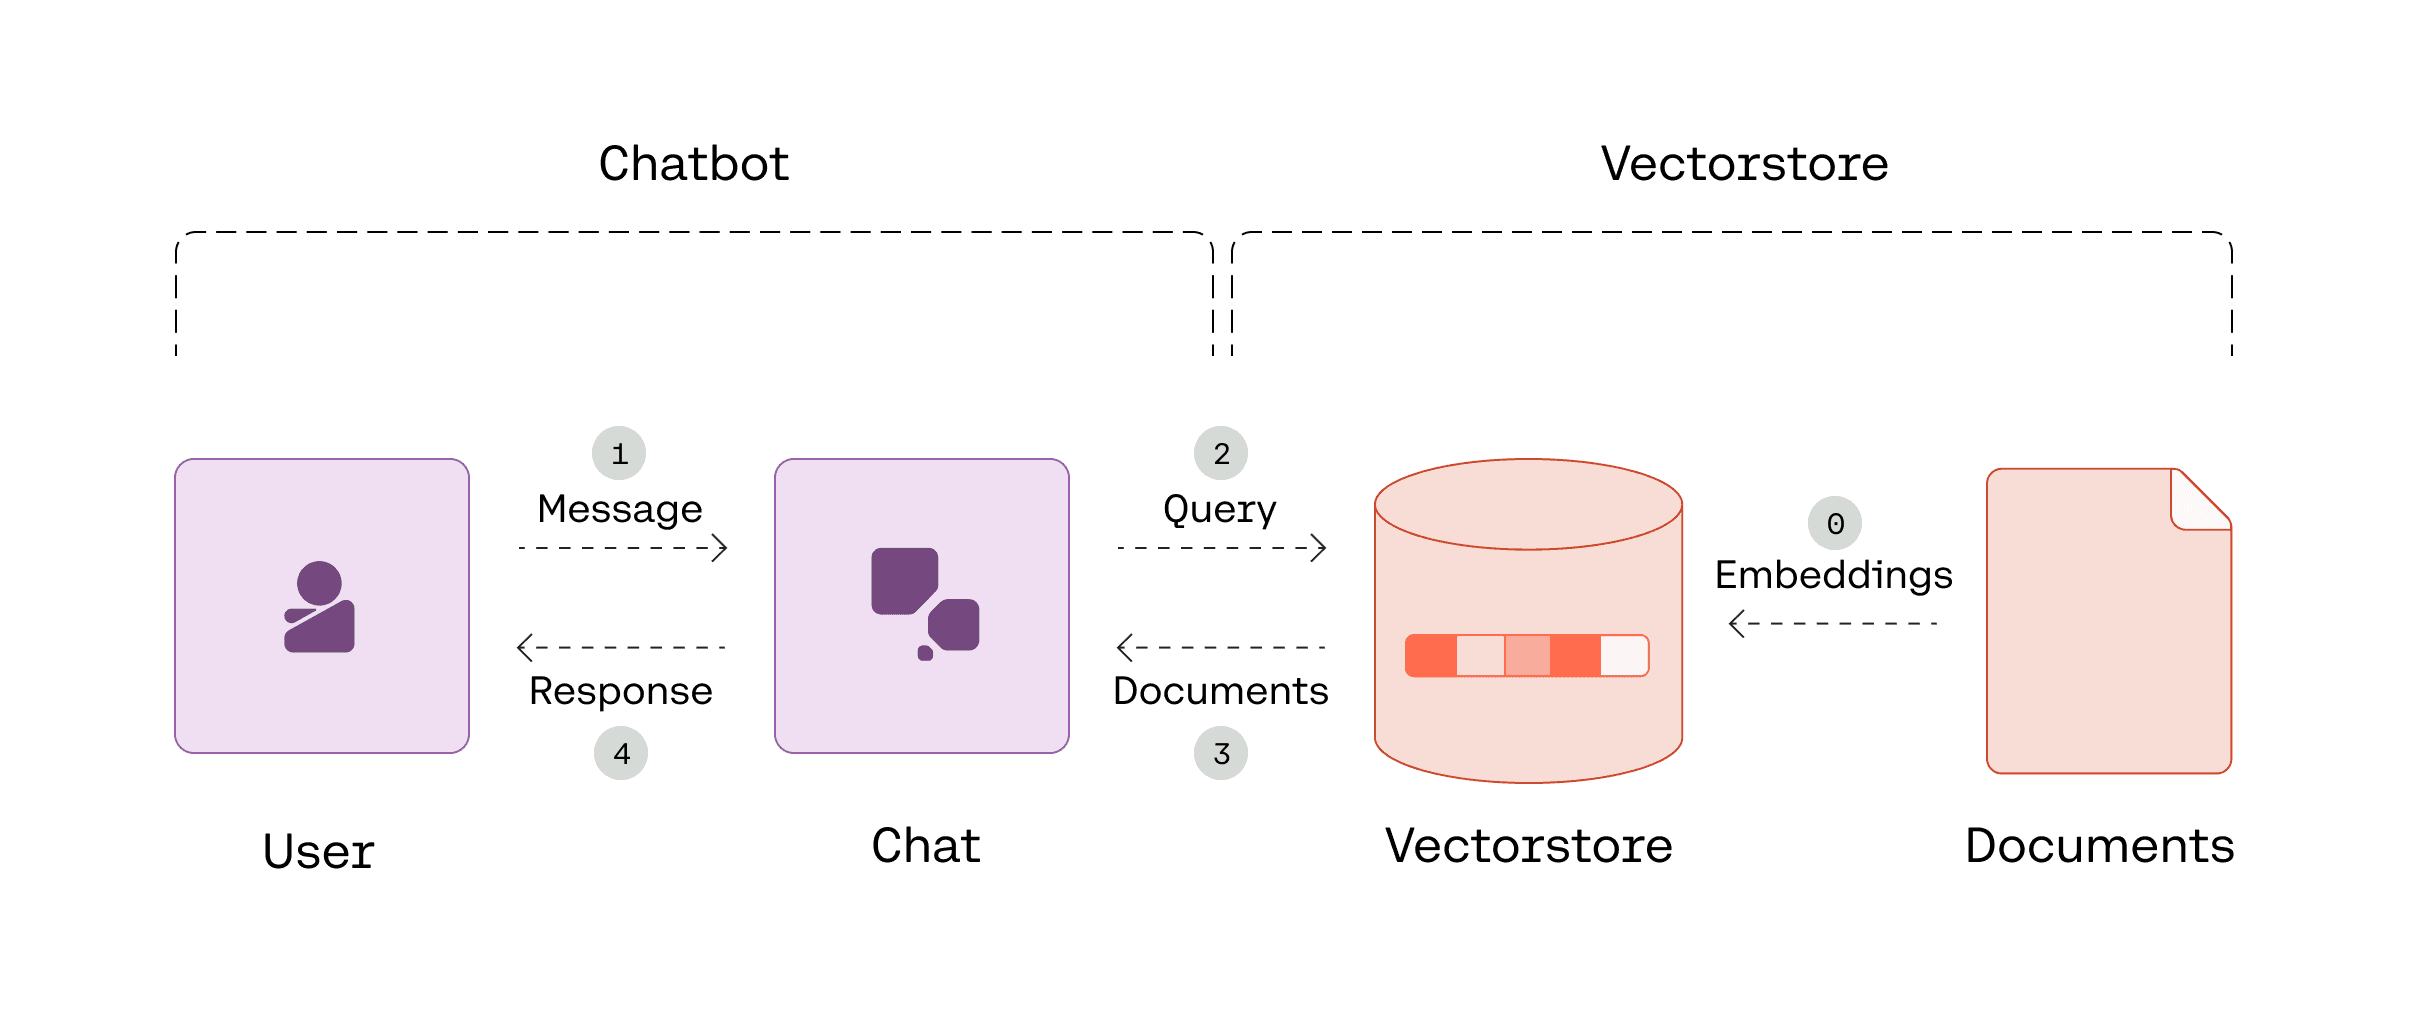
### We will start by creating the context chat class again, but see how we can do it easier with the Cohere SDK
#### (notice no prompt engineering and fusion of multiple queries)

In [580]:
class CohereContextChat(Chat):
    def _multi_search(self, queries):
        all_documents = []
        for query in queries:
            # get the search results
            keyword_documents = search(query, mode='lexical')
            semantic_documents = search(query, mode='semantic')
            hybrid_documents = search(query, mode='hybrid')
            
            # If we want to use rerank
            if self.rerank:
                documents = self._rerank_documents(query, keyword_documents, semantic_documents, top_n=5)
                all_documents.extend(documents)                             
                                          
        return all_documents
        
    def chat(self, message):
        """
        Generates a chat response based on the given message.

        Args:
            message (str): The user's input message.

        Yields:
            str: The chat response generated by the model.
        """
        # get search queries
        generated_queries = co.chat(message=message, model='command-r', search_queries_only=True)
        queries = [q.text for q in generated_queries.search_queries]
        print(f"Queries: {queries}")
        
        # get the search results
        documents = self._multi_search(queries)
        documents = [{'title': d.title, 'text': d.text} for d in documents]
            
        # Chat model        
        model_response = co.chat_stream(
            message=message,
            model="command-r-plus",
            documents=documents,
            temperature=0.1,
            conversation_id=self.convo_id
        )
        
        citations = []
        for token in model_response:
            if token.event_type == 'text-generation':
                yield token.text
            elif token.event_type == 'citation-generation':
                citations.append(token.citations)
        print(f"\n\n{citations}")

In [581]:
cohere_session = CohereContextChat(rerank=True)

#### And we also get citations as part of our response now!

In [582]:
start_time = time.time()

# Asking our question
res = cohere_session.chat('Have there been any studies on natural treatment for diabetes? Also can you search for some of the early signs')

first_token = next(res)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time before the response starts printing: {elapsed_time:.2f} seconds\n")
print(first_token, end='')
for r in res:
    print(r, end='')

Queries: ['natural treatment for diabetes', 'early signs of diabetes']
Time before the response starts printing: 4.07 seconds

There have been studies on natural treatments for diabetes. One such study focused on the efficacy of the Tangminling pill, a Chinese herbal medication consisting of ten herbal medications, which is usually prescribed for type 2 diabetes in mainland China. The study found that Tangminling treatment exhibited better efficacy than a placebo in reducing hemoglobin A1c, fasting plasma glucose, and 2-hour postprandial glucose. Another study focused on the antidiabetic properties of the leaves of Lagerstroemia speciosa (Lythraceae), a Southeast Asian tree more commonly known as banaba. Filipinos have traditionally consumed the leaves of this tree in various forms to treat diabetes and kidney-related diseases. In the 1990s, this herbal medicine began to attract the attention of scientists worldwide, who have since conducted numerous in vitro and in vivo studies that h